# QGraphs - Model analysis

*This notebook analyses* ***QGgraphs (Quantum Digraphs)*** *using* ***Networkx+PennyLane+PyTorch**.*

**By:** Jacob Cybulski<br>
**Date:** August-December 2024<br>
**Aims:** The goal of this notebook is to analyse *Quantum Digraph (QGraphs)* and their performance.<br/>

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/miniconda3/envs/pl-cuda12/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/site-packages',
 '.']

In [2]:
### General libraries

import matplotlib.pyplot as plt
import matplotlib.patches as pltpat
import pylab
import copy
import math
import os
from IPython.display import clear_output

from matplotlib import set_loglevel
set_loglevel("error")

%matplotlib inline

In [3]:
### PennyLane and Torch

import pennylane as qml
from pennylane import numpy as np

# Pytorch imports
import torch
from torch import nn, tensor, optim
import torchvision

In [4]:
# Import local utilities

from utils.Circuits import *
from utils.Charts import *
from utils.Digraphs import *
from utils.Files import *
from utils.PennyLane import *

## Define log details

In [5]:
### Print options
#   0 - Print nothing
#   1 - Print essentials
#   2 - Print all
#   3 - Print debugging info

info_level = 1

In [6]:
### Software version
MAJOR = 1
MINOR = 14

### Constants
LOG_NAME = 'logs'
CASE_NAME = 'bench'
DATA_NAME = 'rand'
GRAPH_PATH = f'{LOG_NAME}/graph'
FIGURES_PATH = f'{LOG_NAME}/figures'
TRAIN_PATH = f'{LOG_NAME}/training'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'

### Create a folder if needed
create_folder_if_needed(GRAPH_PATH)
create_folder_if_needed(FIGURES_PATH)
create_folder_if_needed(TRAIN_PATH)
create_folder_if_needed(ANALYSIS_PATH)

### Show constants
if info_level > 0:
    print(f'LOG_NAME: {LOG_NAME}, CASE_NAME: {CASE_NAME}, DATA_NAME: {DATA_NAME}\n'+ 
          f'GRAPH_PATH: {GRAPH_PATH}, FIGURES_PATH: {FIGURES_PATH}, TRAIN_PATH: {TRAIN_PATH}, ANALYSIS_PATH: {ANALYSIS_PATH}')

LOG_NAME: logs, CASE_NAME: bench, DATA_NAME: rand
GRAPH_PATH: logs/graph, FIGURES_PATH: logs/figures, TRAIN_PATH: logs/training, ANALYSIS_PATH: logs/analysis


## Define devices

In [7]:
### Find what devices are available

# Type to be used with tensors
dtype = torch.float64
torch.set_default_dtype(dtype)

# Quantum simulator
sim = 'default.qubit' # default.qubit lightning.qubit lightning.gpu

# Enable CUDA device if available
torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if info_level > 0: print(f'\nThe optimum devices: {sim} and {torch_device}')

# Force CPU to avoid moving computation and data back and from the GPU
torch_device = "cpu"

if info_level > 0: print(f'Devices to be used:  {sim} and {torch_device}\n')


The optimum devices: default.qubit and cuda:0
Devices to be used:  default.qubit and cpu



## Load training parameters

In [8]:
TRAIN_ID = 'bench_rand_016_025_v011_n004_x001_lays003_Rxyz_h16_ep2000'

In [9]:
### Load the info file
info_fpath = f'{TRAIN_PATH}/{TRAIN_ID}/info.json'
train_info = read_json_file(info_fpath)
    
print(f'\nLoaded training info in file "{info_fpath}":\n')
for k in train_info.keys():
    print(f'\tinfo[{k}] = {train_info[k]}')
print()


Loaded training info in file "logs/training/bench_rand_016_025_v011_n004_x001_lays003_Rxyz_h16_ep2000/info.json":

	info[case_name] = bench
	info[major_version] = 1
	info[minor_version] = 14
	info[data_name] = rand
	info[graph_id] = 016_025_v011
	info[graph_version] = 11
	info[graph_vertices] = 16
	info[graph_edges] = 26
	info[graph_p] = 0.1015625
	info[n_data] = 4
	info[n_extra] = 1
	info[n_wires] = 5
	info[n_layers] = 3
	info[rot] = Rxyz
	info[mode] = h16
	info[iters] = 10
	info[epochs] = 2000
	info[log_interv] = 10
	info[scaler] = 3.141592653589793
	info[shots] = 1000
	info[seed] = 2024
	info[opt_thr] = 0.23
	info[opt_loss] = MSELoss
	info[opt_name] = Adam



In [10]:
saved_case=train_info['case_name'] 
saved_major=train_info['major_version'] 
saved_minor=train_info['minor_version']
saved_data=train_info['data_name']

Graph_ID=train_info['graph_id']
graph_vers=train_info['graph_version']
graph_vertices=train_info['graph_vertices']
graph_edges=train_info['graph_edges']
graph_p=train_info['graph_p']

n_data=train_info['n_data']
n_extra=train_info['n_extra']
n_wires=train_info['n_wires']
n_layers=train_info['n_layers']
rot=train_info['rot']
mode=train_info['mode']

iters=train_info['iters']
epochs=train_info['epochs']
log_interv=train_info['log_interv']
scaler=train_info['scaler']
shots=train_info['shots']
seed=train_info['seed']
opt_thr=train_info['opt_thr']
opt_loss=train_info['opt_loss']
opt_name=train_info['opt_name']

## Load the digraph

In [11]:
### Loading a graph from a file
G_path = f'{GRAPH_PATH}/digraph_{Graph_ID}/wei.json'
G = load_digraph(G_path)
G_det = digraph_details(G)
n_vertices = len(G_det['nodes'])
n_edges = len(G_det['links'])

if info_level > 1: 
    print('\nGraph details:\n')
    display(G_det)
    draw_weighted_digraph(G, 'weight', ax=None)
if info_level > 0:
    print(f'\nLoaded graph from file: {G_path}')
    print(f'Version = {graph_vers}, Actual vertices = {n_vertices}, Actual edges = {n_edges}\n')


Loaded graph from file: logs/graph/digraph_016_025_v011/wei.json
Version = 11, Actual vertices = 16, Actual edges = 26



## Load training data

In [12]:
### Load training parameters
opt_params = read_obj_file(f'{TRAIN_PATH}/{TRAIN_ID}/qopt_params.pkl')
hist_params = read_obj_file(f'{TRAIN_PATH}/{TRAIN_ID}/qhist_params.pkl')
opt_point = read_obj_file(f'{TRAIN_PATH}/{TRAIN_ID}/qopt_point.pkl')
hist_loss = read_obj_file(f'{TRAIN_PATH}/{TRAIN_ID}/qhist_loss.pkl')

In [13]:
### Load threshold scores
mse_scores = read_obj_file(f'{TRAIN_PATH}/{TRAIN_ID}/thr_mse_scores.pkl')
mae_scores = read_obj_file(f'{TRAIN_PATH}/{TRAIN_ID}/thr_mae_scores.pkl')
r2_scores = read_obj_file(f'{TRAIN_PATH}/{TRAIN_ID}/thr_r2_scores.pkl')
jsd_scores = read_obj_file(f'{TRAIN_PATH}/{TRAIN_ID}/thr_jsd_scores.pkl')

In [14]:
### Load resulting and optimum graph
res_G = load_digraph(f'{GRAPH_PATH}/digraph_{Graph_ID}/res.json')
opt_G = load_digraph(f'{GRAPH_PATH}/digraph_{Graph_ID}/opt.json')

### Remind the model and its params

In [15]:
if info_level > 0:
    print(f'\nModel training hyper-parameters:\n'+
        f'\n'+
        f'G_ID = "{Graph_ID}"\n'+
        f'G_path = "{G_path}"\n'+
        f'n_vertices = {n_vertices}\n'+
        f'n_edges = {n_edges}\n'+
        f'\n'+
        f'n_layers = {n_layers}\n'+
        f'n_data = {n_data}\n'+
        f'n_extra = {n_extra}\n'+
        f'n_wires = {n_wires}\n'+
        f'rot = "{rot}"\n'+
        f'\n'+
        f'scaler = {scaler}\n'+
        f'shots = {shots}\n'+
        f'seed = {seed}\n'+
        f'epochs = {epochs}\n'+
        f'log_interv = {log_interv}\n'+
        f'\n'+
        f'opt_loss = {opt_loss}\n'+
        f'opt_name = {opt_name}\n'+
        f'opt_thr = {opt_thr}\n'+
        f'')


Model training hyper-parameters:

G_ID = "016_025_v011"
G_path = "logs/graph/digraph_016_025_v011/wei.json"
n_vertices = 16
n_edges = 26

n_layers = 3
n_data = 4
n_extra = 1
n_wires = 5
rot = "Rxyz"

scaler = 3.141592653589793
shots = 1000
seed = 2024
epochs = 2000
log_interv = 10

opt_loss = MSELoss
opt_name = Adam
opt_thr = 0.23



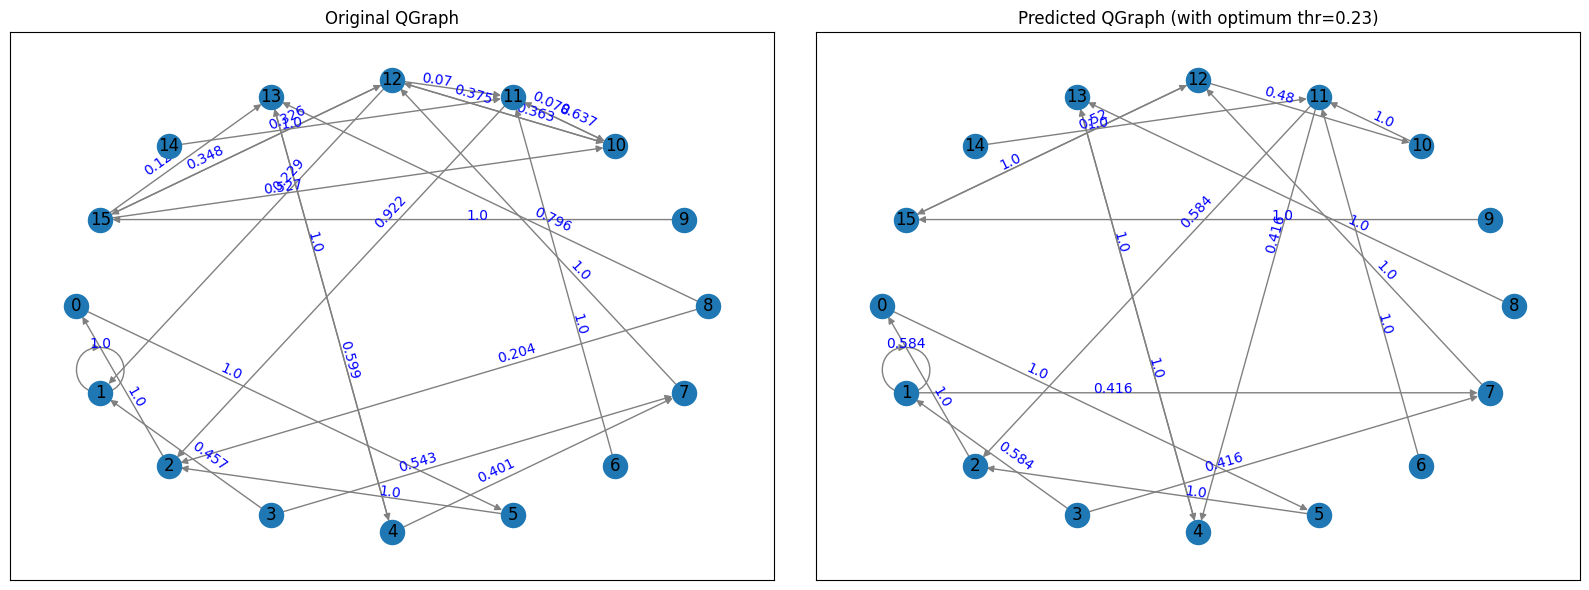

In [16]:
### Compare the original and resulting graph (with optimum threshold)
draw_weighted_digraphs([G, opt_G], titles=['Original QGraph', f'Predicted QGraph (with optimum thr={np.round(opt_thr, 4)})'],
                       attr_name='weight', rcParams=(16, 6))

## Analysis of results

In [17]:
### Print statistical scores
from sklearn.metrics import auc

### Find the threshold span
thr_dx = 1.0/len(mse_scores)
thr_list = np.arange(0.0, 1.0, thr_dx).numpy()

### Retrieve expected and observed digraph weights
expect = digraph_to_adjmat(G)
result = digraph_to_adjmat(res_G)
opt_result = digraph_to_adjmat(opt_G)

### Print optimum scores
idx = np.where(thr_list>=opt_thr)[0][0]
if info_level > 0:
    print(f'\nScores (original vs predicted) @ optimum thr={opt_thr}\n')
    print(f'\tMSE\t= {np.round(mse_scores[idx], 4)}')
    print(f'\tMAE\t= {np.round(mae_scores[idx], 4)}')
    print(f'\tR2\t= {np.round(r2_scores[idx], 4)}')
    print(f'\tJSD\t= {np.round(jsd_scores[idx], 4)}')
    print(f'\nScores comparing models (all thresholds vs predicted)\n')
    print(f'\tR2-AUC\t= {np.round(auc(thr_list,r2_scores), 3)}\n')


Scores (original vs predicted) @ optimum thr=0.23

	MSE	= 0.0085
	MAE	= 0.0225
	R2	= 0.8082
	JSD	= 0.1067

Scores comparing models (all thresholds vs predicted)

	R2-AUC	= 0.515



In [18]:
### Print results
#   From: First columns has the "from" vertext numbers
#   To: First row indicates the "to" vertex numbers
#   exp/res: indicates whether the row represents expected edge weight or its observed probability

if info_level > 2:
    # Heading
    print(f'{"From:": <5} {"To:": <5}', end='')
    for r in range(result.shape[0]):
        print(f'{r:< 8}', end='')
    print()
    
    # Rows
    for r in range(result.shape[0]):
        row_expects = [f'{np.abs(n):.4f}' for n in expect[r]]
        row_results = [f'{np.abs(n):.4f}' for n in opt_result[r]]
        print(f'{r: <5} exp = {"  ".join(row_expects)}  = {sum(expect[r]): <.4f}')
        print(f'{"": <5} obs = {"  ".join(row_results)}  = {sum(np.abs(opt_result[r])): <.4f}\n')

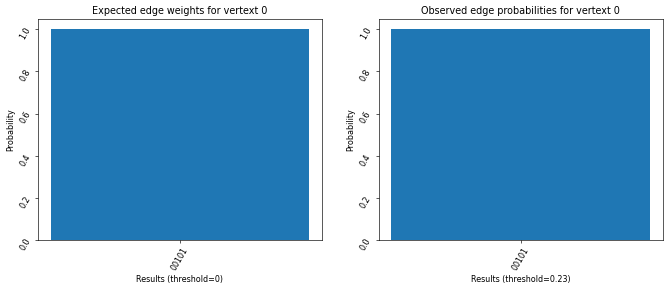

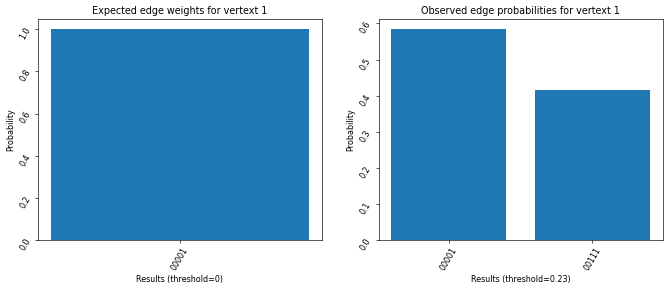

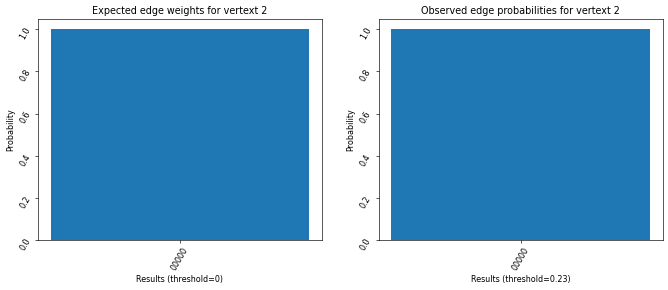

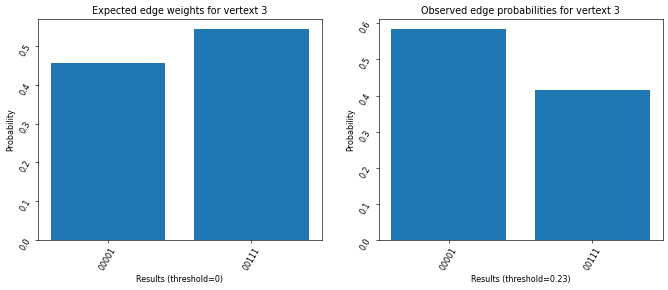

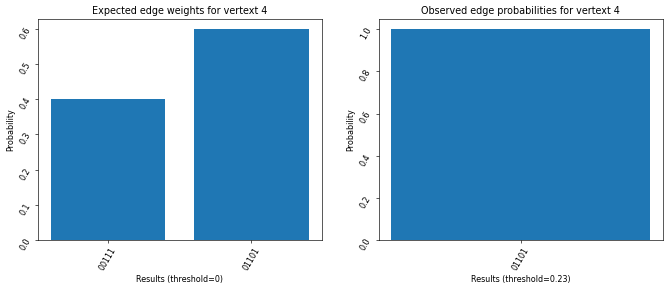

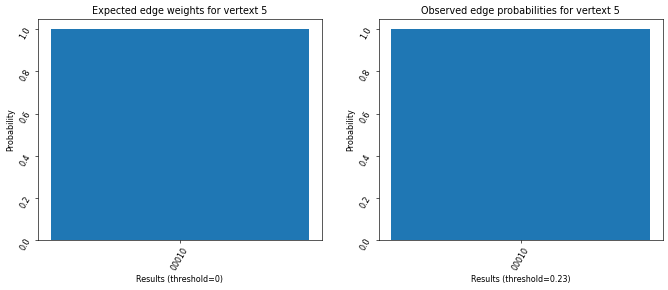

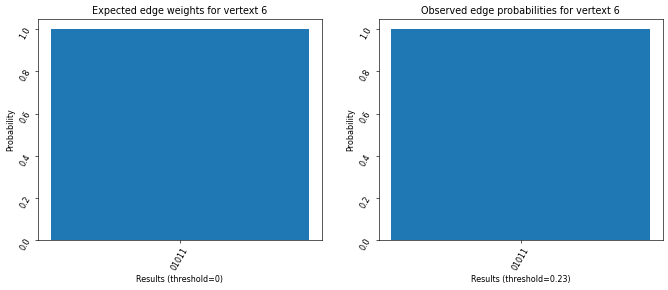

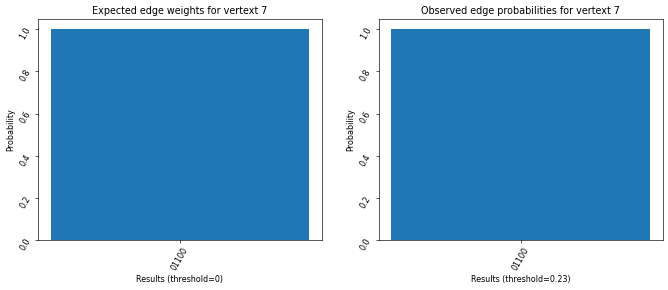

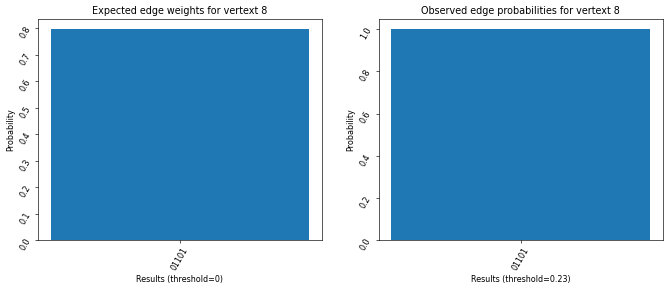

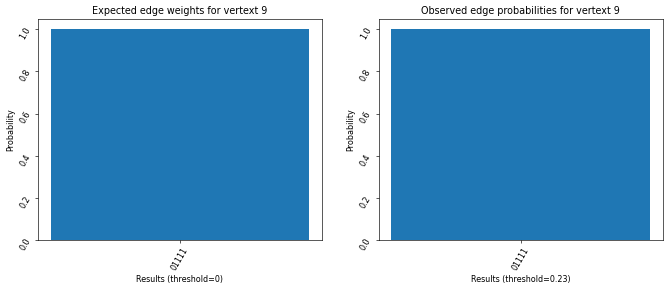

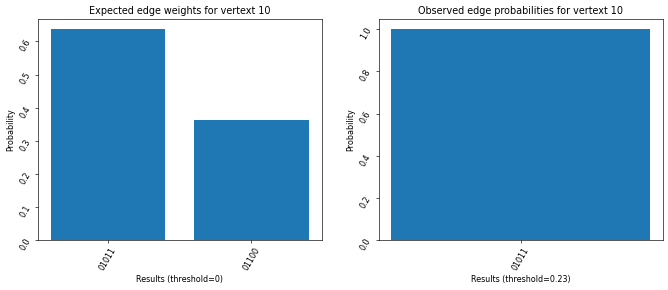

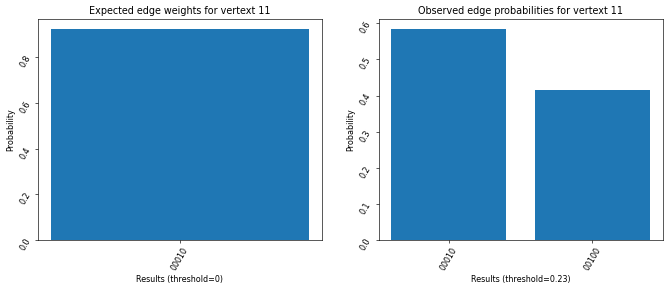

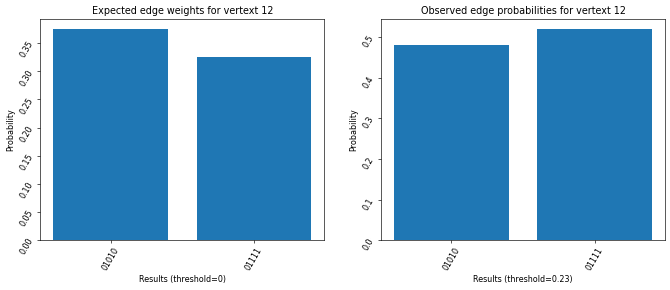

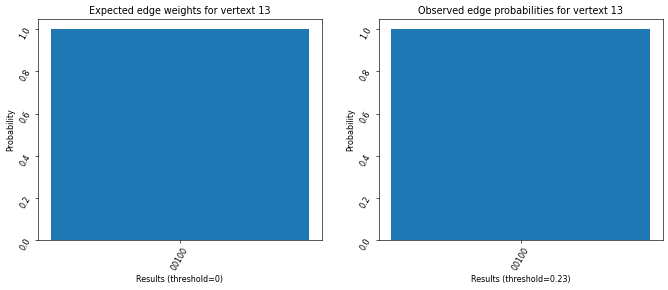

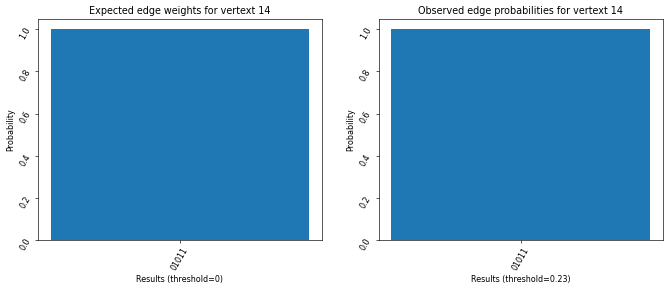

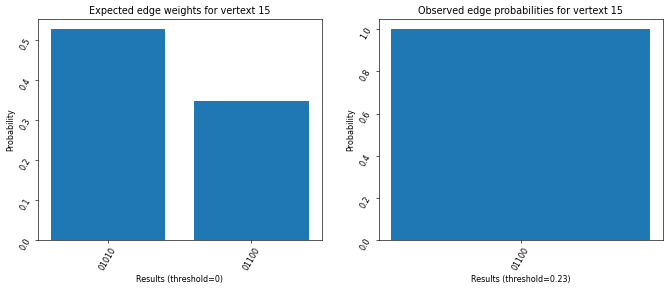

In [19]:
### Plots expected vs observed edge weight distribution
if info_level > 0:
    for r in range(opt_result.shape[0]):
        plot_compare_hist(expect[r], opt_result[r], scale=0.8, figsize=(14, 5), dpi=72, th=opt_thr, 
                title_1=f'Expected edge weights for vertext {r}', title_2=f'Observed edge probabilities for vertext {r}',
                xlabel_1=f'Results (threshold={0})', xlabel_2=f'Results (threshold={opt_thr})')

## Issues

**V1_XX** Training
- Fixed 14 (241230) Split analysis away from training

## System

In [20]:
import sys
print(f'Environment:\n\n{sys.prefix}\n')

Environment:

/home/jacob/miniconda3/envs/pl-cuda12



In [21]:
import os
print(f"Significant packages:\n")
os.system('pip list | grep -e torch -e PennyLane -e networkx');

Significant packages:

networkx                  3.4.2
PennyLane                 0.39.0
PennyLane_Lightning       0.39.0
PennyLane_Lightning_GPU   0.39.0
PennyLane-Rigetti         0.39.0
torch                     2.5.1
torch_geometric           2.5.3
torchaudio                2.5.1
torcheval                 0.0.7
torchsummary              1.5.1
torchvision               0.20.1
